In [2]:
# import
from shapely.ops import cascaded_union  # , unary_union
import matplotlib.pyplot as plt
import tempfile
import urllib
import base64
import h3
from shapely.geometry import mapping
from geopandas import GeoDataFrame
import xarray as xr
import geopandas
import rtree
import shapely
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import matplotlib
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

#Functions


def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16, 12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col, edgecolors='none',
                    colormap=colormap, marker=marker, alpha=alpha, figsize=figsize)
    plt.xticks([], [])
    plt.yticks([], [])


def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(
        lambda x: h3.h3_to_parent(x, coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[
        [metric_col, ]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfc


def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]]
    dfk.index = dfk[hex_col]
    dfs = (dfk[hex_col]
           .apply(lambda x: pd.Series(list(h3.k_ring(x, k)))).stack()
           .to_frame('hexk').reset_index(1, drop=True).reset_index()
           .merge(df[[hex_col, metric_col]]).fillna(0)
           .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
           .reset_index()
           .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]

    # weighted smoothing
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col, inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K = len(coef)-1
    for k in range(1, K+1):
        temp2.append((df_agg['hexk']
                      .apply(lambda x: pd.Series(list(h3.hex_ring(x, k)))).stack()
                      .to_frame('hexk').reset_index(1, drop=True).reset_index()
                      ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x: coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(
        index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


Text(0.5, 1.0, '南京市公共设施')

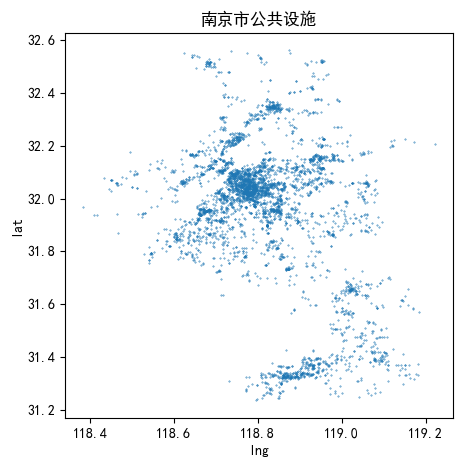

In [6]:
# load the 311 noise complaints
df311 = pd.read_csv('公共设施.csv', encoding='gbk')

# Visualize the 311 noise complaints points
# df311.plot(x='lng', y='lat', style='.', alpha=1, )

df311.plot.scatter(x='lng', y='lat', marker='.', s=0.5, figsize=(5, 5), alpha=1)
plt.title('南京市公共设施')
# df311


Text(0.5, 1.0, 'hex-grid: noise complaints')

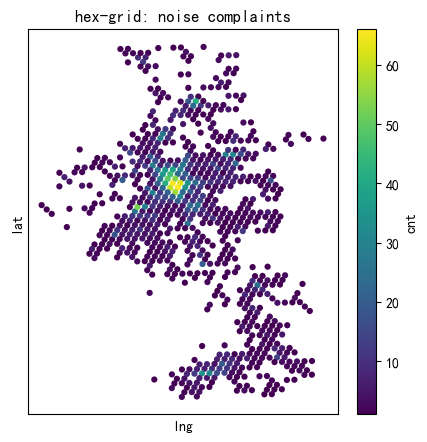

In [3]:
APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, APERTURE_SIZE), 1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
df311g['lat'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311g['lng'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df311g, metric_col='cnt', marker='o', figsize=(5, 5))
plt.title('hex-grid: noise complaints')


In [8]:
df311g

,hex7,cnt,lat,lng
0,873082496ffffff,4,32.525696,118.962945
1,873090241ffffff,1,31.946907,118.469742
2,873090249ffffff,2,31.932052,118.529346
3,87309024dffffff,3,31.948608,118.514483
4,873090255ffffff,1,31.927769,118.417477
...,...,...,...,...
789,87309edb0ffffff,2,31.386141,119.061462
790,87309edb1ffffff,14,31.386976,119.083615
791,87309edb3ffffff,1,31.369511,119.076150
792,87309edb4ffffff,2,31.402770,119.046770


sum sanity check: 1.0


Text(0.5, 1.0, '克里金插值结果')

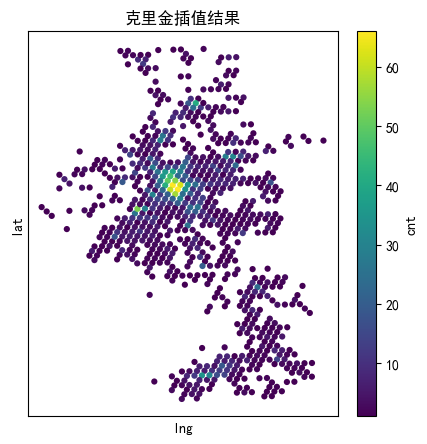

In [10]:
#kring_smoothing
k = 2
df311s = kring_smoothing(df311g, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', df311g['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311g, metric_col='cnt', marker='o', figsize=(5, 5))
plt.title('克里金插值结果')


In [13]:
from shapely.geometry import Polygon
import json

geojson_out = {
    "type": "FeatureCollection",
    "features": []
}

for i in range(len(df311g)):
    geojson_out["features"].append({
        "type": "Feature",
        "properties": {
            "identifier": i
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                h3.h3_to_geo_boundary(df311g['hex7'][i], geo_json=True)
            ]
        },
        'properties': {
            "count": int(df311g['cnt'][i]),
        }
    })

# geojson_out
with open("./南京市公共设施.json", "w", encoding='utf-8') as outfile:
    json.dump(geojson_out, outfile, ensure_ascii=False, indent=4)
